In [32]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.color
import torch
from skimage import io

from model.resnet_unet import ResNetBasedUNet

device = torch.device('cuda')

def load_bw_image(path):
    # Crop so that both dimensions are multiples of 32
    original = io.imread(path)[4:-4].astype(np.float32)
    L_channel = (original[:, :, 0] - 128) / 128
    L_channel = np.expand_dims(L_channel, axis=[0, 1])
    return L_channel

def load_color_image(path):
    # Crop so that both dimensions are multiples of 32
    original = io.imread(path)[4:-4]
    image = skimage.color.rgb2lab(original).astype(np.float32)
    L_channel = (image[:, :, 0] - 50) / 50
    L_channel = np.expand_dims(L_channel, axis=[0, 1])
    return original, L_channel

In [4]:
model_path = '/mnt/Research/ShanghaiProject/code/checkpoint/lr0.0001_2020-05-18-19-20-25/epoch999_end.pt'
model = torch.nn.DataParallel(ResNetBasedUNet().to(device))

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [42]:
image_path = '/mnt/Research/ShanghaiProject/test-dataset/test/1166.png'
image2_path = '/mnt/Research/ShanghaiProject/test-dataset/test/1137.png'
image3_path = '/mnt/Research/ShanghaiProject/test-dataset/train/186.png'
image4_path = '/mnt/Research/ShanghaiProject/bw-frames/705.png'

# original_image, L_channel = load_color_image(image3_path)
L_channel = load_bw_image(image4_path)
# print(f'Image shape: {original_image.shape}')
print(f'L channel shape: {L_channel.shape}')

L channel shape: (1, 1, 352, 480)


In [43]:
output = model(torch.tensor(L_channel).to(device))
print(f'Predictions shape: {output.shape}')

Predictions shape: torch.Size([1, 2, 352, 480])


Lab shape: (352, 480, 3)
Mean in L channel: 46.33160677823153
Mean in a channel: 13.471404105128551
Mean in b channel: 13.620331419310109


/home/chen/.anaconda3/envs/shanghai/lib/python3.8/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2619 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


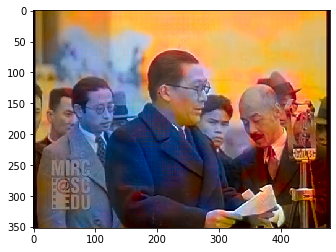

In [44]:
ab_channels = output.squeeze().cpu().detach().numpy()
Lab = np.concatenate([L_channel[0], ab_channels], axis=0)
Lab = Lab.transpose((1, 2, 0))
print(f'Lab shape: {Lab.shape}')

Lab = (Lab * [50, 128, 128] + [50, 0, 0])
print(f'Mean in L channel: {Lab[:, :, 0].mean()}')
print(f'Mean in a channel: {Lab[:, :, 1].mean()}')
print(f'Mean in b channel: {Lab[:, :, 2].mean()}')

rgb_output = skimage.color.lab2rgb(Lab)

plt.imshow(rgb_output)
